# Proyecto de comparación de distintas arquitecturas de redes neuronales para la resolución del problema rock-paper-scissors
Alumnos:
1. Oriol
2. Mei

# 1. Configuración del Entorno y Herramientas

## 1.1 Importación de librarias y detección de Hardware

Importación de las librerías que se usara

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import time
import psutil
import gc
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from typing import Dict, List, Tuple, Any


Se configuran las semillas para reproducibilidad y se prepara el dispositivo. Dado que estamos ejecutando en un MacBook M4 Pro, utilizaremos el backend mps (Metal Performance Shaders) para aceleración por GPU.

In [2]:

# Configuración de Semillas para Reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Detección de Dispositivo (Prioridad MPS para Apple Silicon)
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"✅ Aceleración MPS activada (Apple Silicon).")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ GPU CUDA detectada.")
    else:
        device = torch.device("cpu")
        print("⚠️ GPU no disponible. Usando CPU.")
    return device

DEVICE = get_device()

# Configuración de Rutas (Ajustar según ubicación real)
BASE_PATH = Path(".")
DATA_PATH = BASE_PATH / "Dataset"
TRAIN_PATH = DATA_PATH / "train"
VALID_PATH = DATA_PATH / "valid"
TEST_PATH = DATA_PATH / "test"
CHECKPOINT_PATH = BASE_PATH / "checkpoints"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

print(f"📂 Directorio de datos: {DATA_PATH.resolve()}")

✅ Aceleración MPS activada (Apple Silicon).
📂 Directorio de datos: /Users/oriolpalacios/MyProjects/Dataset


In [21]:
import gc

def get_memory_usage():
    """Returns current memory usage in GB"""
    if device.type == "mps":
        # Unified memory approximation
        return psutil.virtual_memory().used / 1e9
    else:
        return 0

def clear_memory():
    """Aggressively free memory between model runs."""
    # Delete model variables if they exist
    for var in ['model', 'ann_default', 'cnn_default', 'best_model', 'best_model_cnn', 
                'train_loader', 'valid_loader', 'test_loader']:
        if var in globals():
            del globals()[var]
    
    # Clear PyTorch MPS cache
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    
    # Force garbage collection
    gc.collect()
    
    print(f"Memory after cleanup: {get_memory_usage():.2f} GB")

In [5]:
def show_errors(model, dataset, max_images=12):
    """Display misclassified images."""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
            if pred != label:
                errors.append((img, label, pred, idx))
            if len(errors) >= max_images:
                break
    
    # Plot
    rows = (len(errors) + 3) // 4
    fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 3))
    axes = axes.ravel()
    
    for i, (img, true, pred, _) in enumerate(errors):
        # Denormalize with same stats used for normalization
        img_disp = img.clone()
        for t, m, s in zip(img_disp, DATASET_STATS['mean'], DATASET_STATS['std']):
            t.mul_(s).add_(m)
        img_disp = torch.clamp(img_disp, 0, 1)
        img_disp = transforms.ToPILImage()(img_disp)
        
        axes[i].imshow(img_disp)
        axes[i].set_title(f"True: {dataset.classes[true]}\nPred: {dataset.classes[pred]}", 
                         color='red')
        axes[i].axis('off')
    
    # Hide empty subplots
    for j in range(len(errors), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f"Misclassifications ({len(errors)} errors)")
    plt.tight_layout()
    plt.show()
    
    return errors

# 2. Dataset Loading and exploration

In [9]:
class HandGestureDataset(Dataset):
    def __init__(self, data_path: Path, transform=None, split_name: str = ""):
        self.dataset = ImageFolder(root=str(data_path), transform=transform)
        self.split_name = split_name
        self._verify_test_split()
    
    def _verify_test_split(self):
        if self.split_name == "test":
            class_counts = {}
            for class_name in self.dataset.classes:
                class_path = Path(self.dataset.root) / class_name
                class_counts[class_name] = len(list(class_path.glob("*.jpg")))
            
            total_images = sum(class_counts.values())
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]
    
    @property
    def classes(self):
        return self.dataset.classes

# Normalization pipelines
# For transfer learning models (MobileNetV3, etc.)
IMAGENET_STATS = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

# For now, use a placeholder (you can compute it later)
DATASET_STATS = {
    'mean': [0.5, 0.5, 0.5],  # Temporary
    'std': [0.5, 0.5, 0.5]
}

# Transforms
train_transform_scratch = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_STATS['mean'], std=DATASET_STATS['std'])
])

valid_transform_scratch = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_STATS['mean'], std=DATASET_STATS['std'])
])

train_transform_imagenet = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_STATS['mean'], std=IMAGENET_STATS['std'])
])

train_transform_imagenet_v2 = transforms.Compose([
    transforms.Resize((300, 300)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45), 
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomResizedCrop(300, scale=(0.7, 1.0)), 
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  
    transforms.RandomGrayscale(p=0.1), 
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform_imagenet = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_STATS['mean'], std=IMAGENET_STATS['std'])
])


# Visualize samples
def plot_dataset_samples(dataset, num_samples=9, title="Dataset Samples"):
    """Plot grid of random samples from dataset (always denormalizes correctly)"""
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Always denormalize using ImageNet stats for display
        # This avoids gray cast regardless of which transform was used
        img_display = image.clone()
        for t, m, s in zip(img_display, DATASET_STATS['mean'], DATASET_STATS['std']):
            t.mul_(s).add_(m)
        
        img_display = torch.clamp(img_display, 0, 1)
        img_display = transforms.ToPILImage()(img_display)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [10]:
# funcion para cambiar los fondos puramente blancos de las imagenes
class ReplaceWhiteBackground:
    def __init__(self, threshold=0.9, p=0.5, noise_type='gaussian'):
        self.threshold = threshold
        self.p = p
        self.noise_type = noise_type

    def __call__(self, img_tensor):
        if random.random() > self.p:
            return img_tensor

        mask = (img_tensor[0] > self.threshold) & \
               (img_tensor[1] > self.threshold) & \
               (img_tensor[2] > self.threshold)

        if self.noise_type == 'gaussian':
            background = torch.randn_like(img_tensor) * 0.5 + 0.5
        elif self.noise_type == 'color':
            background = torch.tensor([random.random(), random.random(), random.random()]).view([3,1,1])
            background = background.expand_as(img_tensor)
        else:
            return img_tensor

        result = img_tensor.clone()
        mask_expanded = mask.unsqueeze(0).expand_as(img_tensor)
        result[mask_expanded] = background[mask_expanded]

        return result

In [11]:
train_transform_imagenet_v2_simplified = transforms.Compose([
    transforms.Resize((300, 300)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45, fill=255), 
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, fill=255),
    transforms.ToTensor(),
    ReplaceWhiteBackground(threshold=0.9, p=0.7, noise_type='color'),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# 3. Arquitecturas planteadas

## 3.1 Simple Artificial Neural Network

### 3.1.1 Arquitectura

In [134]:
class SimpleANN(nn.Module):
    def __init__(self, input_size=300*300*3, hidden_sizes=[512, 256], 
                 dropout_rate=0.2, use_batchnorm=True, num_classes=3):
        super(SimpleANN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

# Test architecture
ann_test = SimpleANN().to(device)
dummy = torch.randn(1, 3, 300, 300).to(device)
print(f"SimpleANN parameters: {sum(p.numel() for p in ann_test.parameters()):,}")

SimpleANN parameters: 138,374,147


In [ ]:
# Load datasets
train_dataset = HandGestureDataset(TRAIN_PATH, train_transform_scratch, "train")
valid_dataset = HandGestureDataset(VALID_PATH, valid_transform_scratch, "valid")
test_dataset = HandGestureDataset(TEST_PATH, valid_transform_scratch, "test")

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset_scratch)} images")
print(f"Valid: {len(valid_dataset_scratch)} images")
print(f"Test: {len(test_dataset)} images")
print(f"Classes: {train_dataset_scratch.classes}")

### 3.1.2 Entrenamiento

In [18]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, 
                num_epochs=8, early_stopping_patience=7, device=device,
                model_name="model", save_dir=CHECKPOINT_PATH):
    """Training loop with early stopping. Returns history and best accuracy."""
    
    save_path = Path(save_dir) / model_name
    save_path.mkdir(parents=True, exist_ok=True)
    
    best_val_acc = 0
    patience = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)
        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        
        # Metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(valid_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:02d} | Train: {train_acc:.4f} | Val: {val_acc:.4f}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc, patience = val_acc, 0
            torch.save(model.state_dict(), save_path / "best.pt")
        else:
            patience += 1
            if patience >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return history, best_val_acc


In [135]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Train default model
ann_default = SimpleANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_default.parameters(), lr=0.001)

print("Training SimpleANN (default hyperparameters)...")
history_default, acc_default = train_model(
    ann_default, train_loader, valid_loader, criterion, optimizer,
    model_name="SimpleANN_default"
)

Training SimpleANN (default hyperparameters)...
Epoch 01 | Train: 0.6179 | Val: 0.3898
Epoch 02 | Train: 0.8786 | Val: 0.5349
Epoch 03 | Train: 0.9409 | Val: 0.4382
Epoch 04 | Train: 0.9575 | Val: 0.5134
Epoch 05 | Train: 0.9687 | Val: 0.3898
Epoch 06 | Train: 0.9766 | Val: 0.3387
Epoch 07 | Train: 0.9726 | Val: 0.5618
Epoch 08 | Train: 0.9798 | Val: 0.7930


### 3.1.3 Visualización de entrenamiento 


Starting hyperparameter search...

--- lr=0.001, batch=16, dropout=0.2 ---
Epoch 01 | Train: 0.5881 | Val: 0.5430
Epoch 02 | Train: 0.8444 | Val: 0.5645
Epoch 03 | Train: 0.9298 | Val: 0.3817
Epoch 04 | Train: 0.9385 | Val: 0.5887
Epoch 05 | Train: 0.9448 | Val: 0.6667
Epoch 06 | Train: 0.9452 | Val: 0.4247
Epoch 07 | Train: 0.9567 | Val: 0.6398
Epoch 08 | Train: 0.9706 | Val: 0.5161

--- lr=0.001, batch=16, dropout=0.5 ---
Epoch 01 | Train: 0.5417 | Val: 0.5726
Epoch 02 | Train: 0.7802 | Val: 0.6828
Epoch 03 | Train: 0.8746 | Val: 0.4946
Epoch 04 | Train: 0.9000 | Val: 0.4919
Epoch 05 | Train: 0.9190 | Val: 0.6048
Epoch 06 | Train: 0.9274 | Val: 0.7312
Epoch 07 | Train: 0.9333 | Val: 0.7392
Epoch 08 | Train: 0.9413 | Val: 0.7608

--- lr=0.001, batch=32, dropout=0.2 ---
Epoch 01 | Train: 0.6647 | Val: 0.6559
Epoch 02 | Train: 0.8964 | Val: 0.5699
Epoch 03 | Train: 0.9401 | Val: 0.6398
Epoch 04 | Train: 0.9714 | Val: 0.5833
Epoch 05 | Train: 0.9643 | Val: 0.4785
Epoch 06 | Train: 0.973

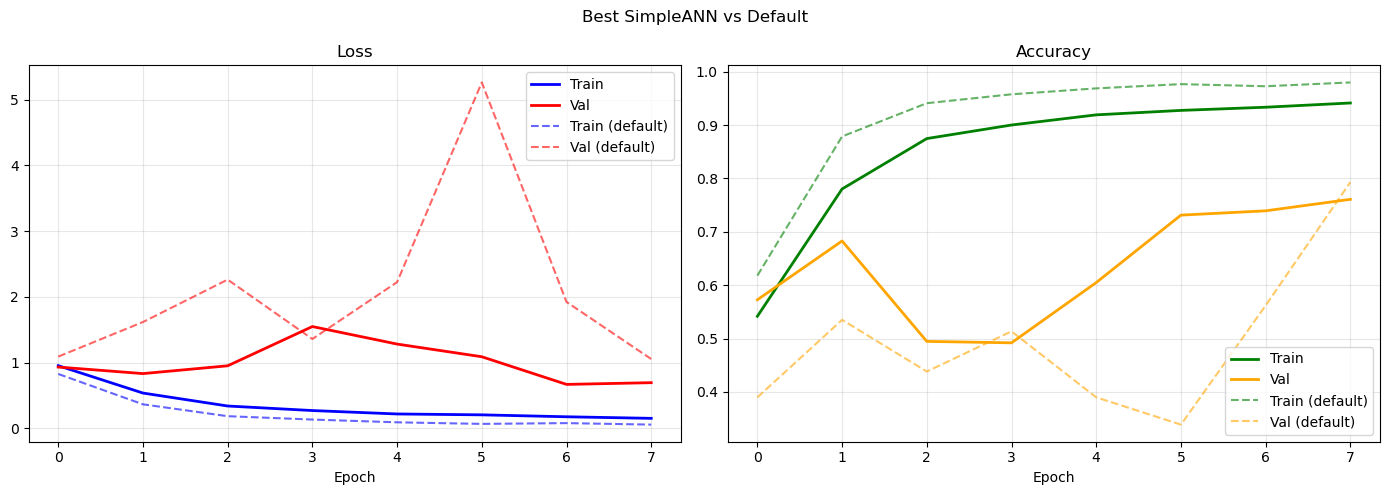

In [136]:
def plot_training_curves(history, title="Training Curves", compare=None):
    """Plot loss and accuracy curves with optional comparison."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train', color='blue', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val', color='red', linewidth=2)
    if compare:
        axes[0].plot(compare['train_loss'], '--', label='Train (default)', color='blue', alpha=0.6)
        axes[0].plot(compare['val_loss'], '--', label='Val (default)', color='red', alpha=0.6)
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train', color='green', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val', color='orange', linewidth=2)
    if compare:
        axes[1].plot(compare['train_acc'], '--', label='Train (default)', color='green', alpha=0.6)
        axes[1].plot(compare['val_acc'], '--', label='Val (default)', color='orange', alpha=0.6)
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Run hyperparameter search
hyperparams = {
    'lr': [0.001, 0.0001],
    'batch_size': [16, 32],
    'dropout': [0.2, 0.5]
}

best_acc = 0
best_config = {}
best_history = None

print("\nStarting hyperparameter search...")
for lr in hyperparams['lr']:
    for bs in hyperparams['batch_size']:
        for dropout in hyperparams['dropout']:
            print(f"\n--- lr={lr}, batch={bs}, dropout={dropout} ---")
            
            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False)
            
            model = SimpleANN(dropout_rate=dropout).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            history, val_acc = train_model(
                model, train_loader, valid_loader, criterion, optimizer,
                model_name=f"SimpleANN_lr{lr}_bs{bs}_do{dropout}"
            )
            
            if val_acc > best_acc:
                best_acc, best_config = val_acc, {'lr': lr, 'batch_size': bs, 'dropout': dropout}
                best_history = history

print(f"\nBest config: {best_config} | Val Acc: {best_acc:.4f}")
plot_training_curves(best_history, "Best SimpleANN vs Default", compare=history_default)

In [144]:
clear_memory()

Memory after cleanup: 7.40 GB


### 3.1.4 Validación sobre test dataset


Test Performance:
Accuracy: 0.6508
Precision: 0.6665
Recall: 0.6541
F1-Score: 0.6494


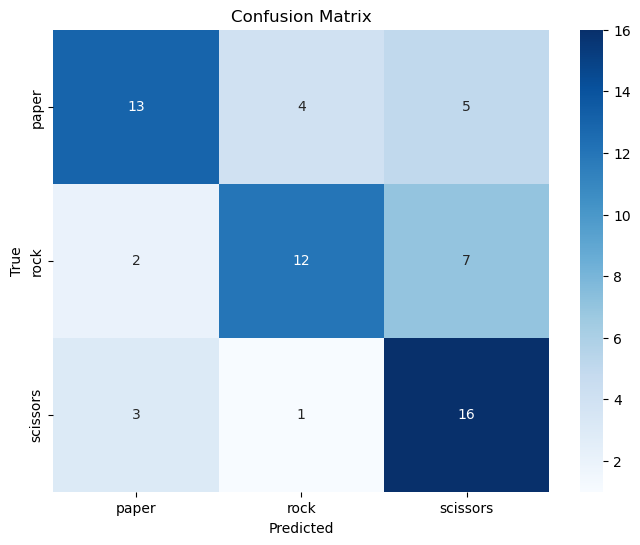

In [146]:
# Load best checkpoint
best_path = CHECKPOINT_PATH / f"SimpleANN_lr{best_config['lr']}_bs{best_config['batch_size']}_do{best_config['dropout']}" / "best.pt"
best_model = SimpleANN(dropout_rate=best_config['dropout']).to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))

# Test evaluation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        test_preds.extend(outputs.argmax(1).cpu().numpy())
        test_labels.extend(labels.numpy())

test_acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='macro', zero_division=0
)

print(f"\nTest Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### 3.1.5 Análisis de errores

In [193]:
error_images = show_errors(best_model, test_dataset)
print(f"\nTotal errors: {len(error_images)} / {len(test_dataset)}")

## 3.2 CNN (diseño propio)

### 3.2.1 Arquitectura

In [163]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.2, use_batchnorm=True, 
                 base_filters=32):
        super(CustomCNN, self).__init__()
        
        def conv_block(in_channels, out_channels):
            layers = []
            layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(out_channels, out_channels,3 ,padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            layers.append(nn.Dropout(dropout_rate))
            return nn.Sequential(*layers)
        
        self.conv1 = conv_block(3, base_filters)
        self.conv2 = conv_block(base_filters, base_filters * 2)
        self.conv3 = conv_block(base_filters * 2, base_filters * 4)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(base_filters * 4, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Test architecture
cnn_test = CustomCNN().to(device)
dummy = torch.randn(1, 3, 300, 300).to(device)
print(f"CustomCNN parameters: {sum(p.numel() for p in cnn_test.parameters()):,}")

CustomCNN parameters: 288,291


### 3.2.2 Entrenamiento

In [164]:
clear_memory()

#Hyperparameter grid (reduced for speed)
hyperparams_cnn = {
    'lr': [0.001],
    'batch_size': [32],
    'dropout': [0.5],
    'base_filters': [16, 32], 
    'use_batchnorm': [True]
}

best_acc_cnn = 0
best_config_cnn = {}
best_history_cnn = None

print("\nStarting CustomCNN hyperparameter search...")
for lr in hyperparams_cnn['lr']:
    for bs in hyperparams_cnn['batch_size']:
        for dropout in hyperparams_cnn['dropout']:
            for filters in hyperparams_cnn['base_filters']:
                for bn in hyperparams_cnn['use_batchnorm']:
                    print(f"\n--- lr={lr}, bs={bs}, do={dropout}, filters={filters}, bn={bn} ---")
                    
                    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                    valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False)
                    
                    model = CustomCNN(dropout_rate=dropout, 
                                    base_filters=filters, 
                                    use_batchnorm=bn).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    
                    history, val_acc = train_model(
                        model, train_loader, valid_loader, criterion, optimizer,
                        model_name=f"CustomCNN_lr{lr}_bs{bs}_do{dropout}_f{filters}_bn{bn}"
                    )
                    
                    if val_acc > best_acc_cnn:
                        best_acc_cnn, best_config_cnn = val_acc, {
                            'lr': lr, 'batch_size': bs, 'dropout': dropout, 
                            'base_filters': filters, 'use_batchnorm': bn
                        }
                        best_history_cnn = history

print(f"\nBest config: {best_config_cnn} | Val Acc: {best_acc_cnn:.4f}")

Memory after cleanup: 12.73 GB

Starting CustomCNN hyperparameter search...

--- lr=0.001, bs=32, do=0.2, filters=16, bn=True ---
Epoch 01 | Train: 0.5111 | Val: 0.5000
Epoch 02 | Train: 0.6500 | Val: 0.6129
Epoch 03 | Train: 0.6881 | Val: 0.5887
Epoch 04 | Train: 0.7714 | Val: 0.6317
Epoch 05 | Train: 0.8048 | Val: 0.6022
Epoch 06 | Train: 0.8115 | Val: 0.5672
Epoch 07 | Train: 0.8361 | Val: 0.4651
Epoch 08 | Train: 0.8687 | Val: 0.6667

--- lr=0.001, bs=32, do=0.2, filters=32, bn=True ---
Epoch 01 | Train: 0.5365 | Val: 0.4973
Epoch 02 | Train: 0.7008 | Val: 0.3333
Epoch 03 | Train: 0.7897 | Val: 0.5914
Epoch 04 | Train: 0.8282 | Val: 0.7984
Epoch 05 | Train: 0.8758 | Val: 0.6667
Epoch 06 | Train: 0.8972 | Val: 0.5108
Epoch 07 | Train: 0.9103 | Val: 0.9194
Epoch 08 | Train: 0.9437 | Val: 0.8387

--- lr=0.001, bs=32, do=0.5, filters=16, bn=True ---
Epoch 01 | Train: 0.4413 | Val: 0.3333
Epoch 02 | Train: 0.5532 | Val: 0.3333
Epoch 03 | Train: 0.6091 | Val: 0.3710
Epoch 04 | Train: 0.6

### 3.2.3 Visualización de entrenamiento

In [ ]:
# tomando uno de los entrenamientos iniciales


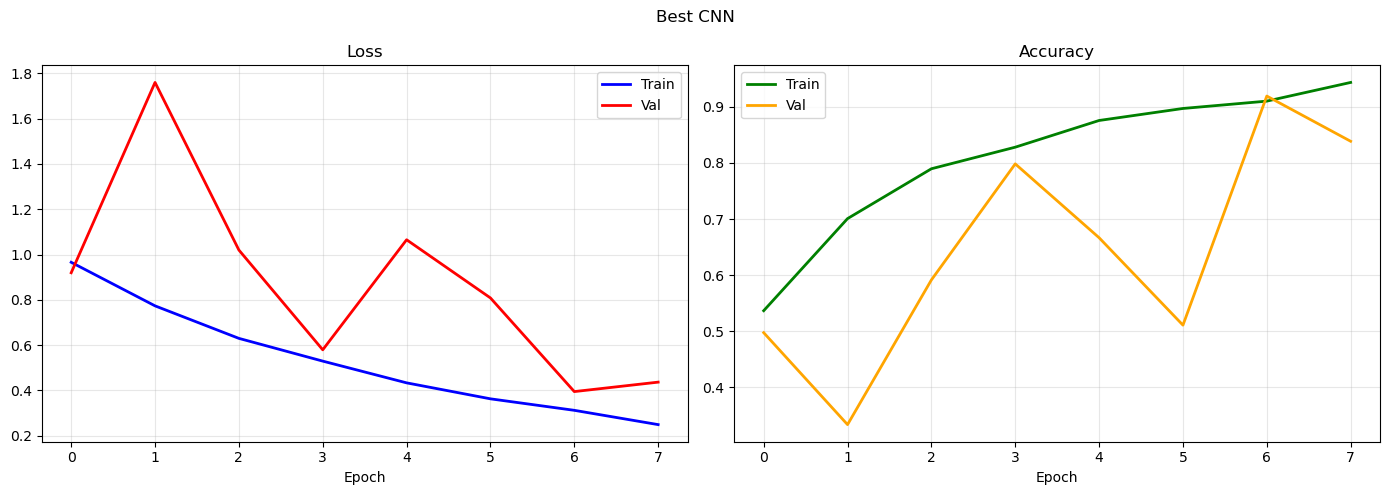

In [165]:
plot_training_curves(best_history_cnn, "Best CNN")

### 3.2.4 Validación sobre test dataset

Memory after cleanup: 8.19 GB

Test Performance (CustomCNN):
Accuracy: 0.5397
Precision: 0.5365
Recall: 0.5359
F1-Score: 0.5287


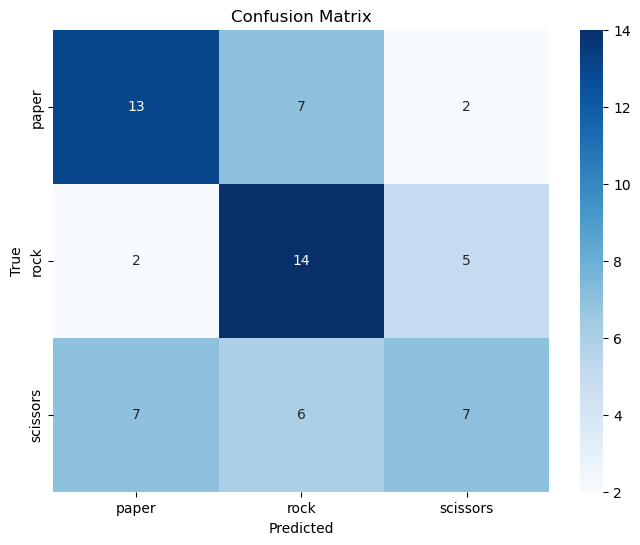

In [166]:
clear_memory()

best_path_cnn = (CHECKPOINT_PATH / f"CustomCNN_lr{best_config_cnn['lr']}_bs{best_config_cnn['batch_size']}_do{best_config_cnn['dropout']}_f{best_config_cnn['base_filters']}_bn{best_config_cnn['use_batchnorm']}/best.pt") 
best_model_cnn = CustomCNN(
    dropout_rate=best_config_cnn['dropout'],
    base_filters=best_config_cnn['base_filters'],
    use_batchnorm=best_config_cnn['use_batchnorm']
).to(device)
best_model_cnn.load_state_dict(torch.load(best_path_cnn, map_location=device))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model_cnn.eval()
test_preds_cnn, test_labels_cnn = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model_cnn(images.to(device))
        test_preds_cnn.extend(outputs.argmax(1).cpu().numpy())
        test_labels_cnn.extend(labels.numpy())

test_acc_cnn = accuracy_score(test_labels_cnn, test_preds_cnn)
precision_cnn, recall_cnn, f1_cnn, _ = precision_recall_fscore_support(
    test_labels_cnn, test_preds_cnn, average='macro', zero_division=0
)

print(f"\nTest Performance (CustomCNN):")
print(f"Accuracy: {test_acc_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1-Score: {f1_cnn:.4f}")
cm = confusion_matrix(test_labels_cnn, test_preds_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### 3.2.5 Análisis de errores

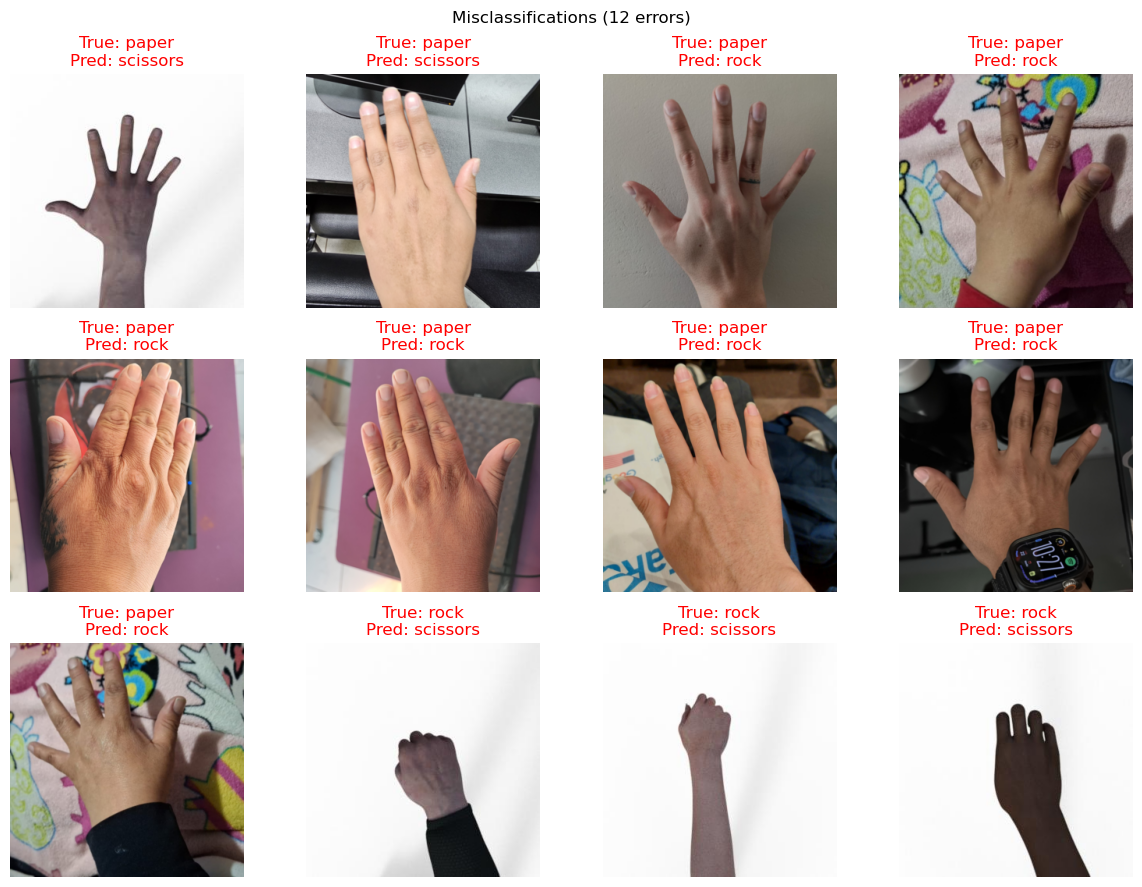


Total errors: 12 / 63


In [167]:
error_images_cnn = show_errors(best_model_cnn, test_dataset)
print(f"\nTotal errors: {len(error_images_cnn)} / {len(test_dataset)}")

## 3.3 Transfer Learning

### 3.3.1 Procesamiento de datos

In [574]:
train_dataset_tl = HandGestureDataset(TRAIN_PATH, train_transform_imagenet, "train")
valid_dataset_tl = HandGestureDataset(VALID_PATH, valid_transform_imagenet, "valid")
test_dataset_tl = HandGestureDataset(TEST_PATH, valid_transform_imagenet, "test")

### 3.3.2 Arquitectura

In [202]:
class TransferLearningCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.6):
        super().__init__()
        
        self.backbone = models.resnet18()
        
        for name, param in self.backbone.named_parameters():
            if 'layer4' not in name and 'layer3' not in name and 'fc' not in name:
                param.requires_grad = False
        
        # Replace classifier with heavy regularization
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def print_named_parameters(self):
        print(self.backbone.named_parameters())
    
    def forward(self, x):
        return self.backbone(x)

### 3.3.3 Entrenamiento

In [200]:
mobnet_test = TransferLearningCNN().to(device)
dummy = torch.randn(1, 3, 300, 300).to(device)
print(f"Restnet18 parameters: {sum(p.numel() for p in mobnet_test.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in mobnet_test.parameters() if p.requires_grad)}")

Restnet18 parameters: 11,242,563
Trainable parameters: 10559491


In [187]:
train_loader = DataLoader(train_dataset_tl, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset_tl, batch_size=32, shuffle=False)

model = TransferLearningCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

history, val_acc = train_model(
    model, train_loader, valid_loader, criterion, optimizer,
    model_name=f"TransferLearningDefault"
)

default_history_transferLearning = history


Epoch 01 | Train: 0.7143 | Val: 0.3683
Epoch 02 | Train: 0.9579 | Val: 0.8065
Epoch 03 | Train: 0.9861 | Val: 0.9220
Epoch 04 | Train: 0.9857 | Val: 0.8414
Epoch 05 | Train: 0.9909 | Val: 0.9892
Epoch 06 | Train: 0.9952 | Val: 0.9892
Epoch 07 | Train: 0.9960 | Val: 0.8414
Epoch 08 | Train: 0.9813 | Val: 0.5511


### 3.3.4 Evaluación del modelo

Memory after cleanup: 11.34 GB

Test Performance (Transfer Learning):
Accuracy: 0.7143
Precision: 0.7297
Recall: 0.7086
F1-Score: 0.7054


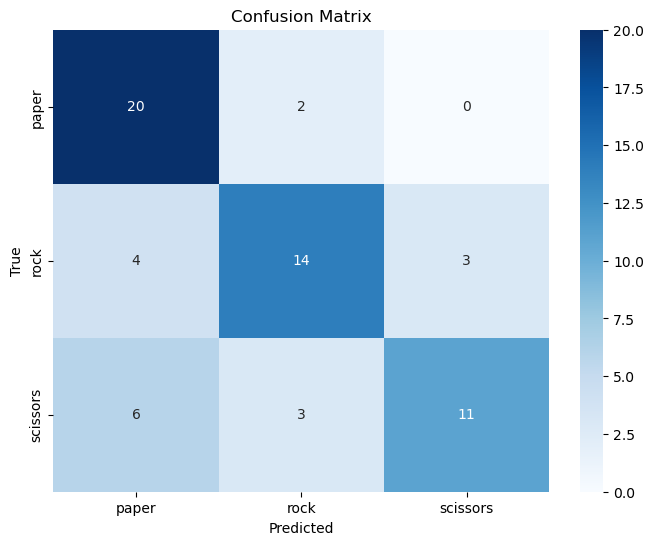

In [188]:
clear_memory()

tl_path = (CHECKPOINT_PATH / f"TransferLearningDefault/best.pt") 
tl_model = TransferLearningCNN().to(device)
tl_model.load_state_dict(torch.load(tl_path, map_location=device))

test_loader = DataLoader(test_dataset_tl, batch_size=32, shuffle=False)

tl_model.eval()
test_preds_tl, test_labels_tl = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = tl_model(images.to(device))
        test_preds_tl.extend(outputs.argmax(1).cpu().numpy())
        test_labels_tl.extend(labels.numpy())

test_acc_tl = accuracy_score(test_labels_tl, test_preds_tl)
precision_tl, recall_tl, f1_tl, _ = precision_recall_fscore_support(
    test_labels_tl, test_preds_tl, average='macro', zero_division=0
)

print(f"\nTest Performance (Transfer Learning):")
print(f"Accuracy: {test_acc_tl:.4f}")
print(f"Precision: {precision_tl:.4f}")
print(f"Recall: {recall_tl:.4f}")
print(f"F1-Score: {f1_tl:.4f}")
cm = confusion_matrix(test_labels_tl, test_preds_tl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

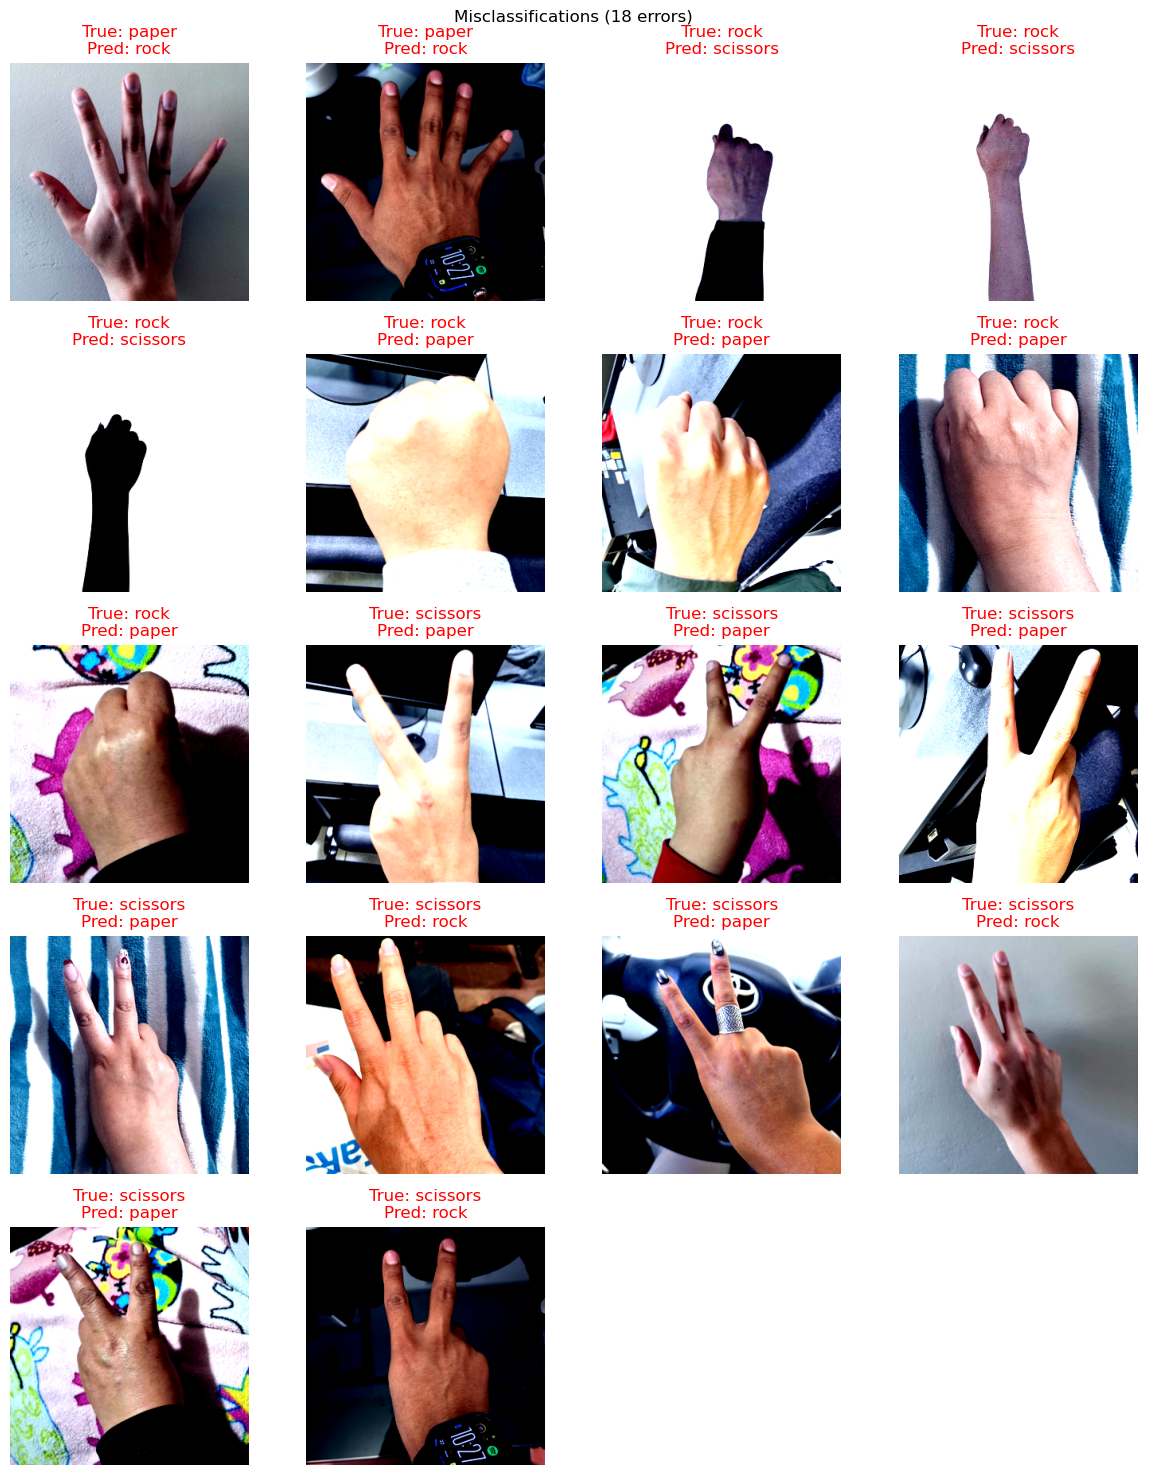


Total errors: 18 / 63


In [198]:
error_images_tl = show_errors(tl_model, test_dataset_tl, max_images=24)
print(f"\nTotal errors: {len(error_images_tl)} / {len(test_dataset_tl)}")

## 3.4 Transfer Learning con transformaciones diferentes y TTA (test time augmentation)

### 3.4.1 Procesamiento de datos

In [523]:
new_train_dataset_tl = HandGestureDataset(TRAIN_PATH, train_transform_imagenet_v2, "train")
model = TransferLearningCNN().to(DEVICE)

### 3.4.2 Implementacion de TTA

In [32]:
def simple_tta(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            out1 = model(images.to(device))
            out2 = model(torch.flip(images, [3]).to(device))
            avg = (torch.softmax(out1,1) + torch.softmax(out2,1))/2
            all_preds.extend(avg.argmax(1).cpu().numpy())
            all_labels.extend(labels)
    return all_preds, all_labels

### 3.4.3 Nueva funcion loss y optimizador

Se establece una funcion de perdida CrossEntropyLoss con label_smoothing para suavizar la distribución de probabilidades que resulta del modelo, evitando las penalizaciones por no hacer match con el 1 o 0 perfecto. Esto dado el overfitting evidente del modelo anterior

In [525]:
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.15)

Se establece un learning rate diferente para las capas convolucionales y la red completamente conectada. 
Se establece un learning rate más pequeño para el backbone dado que se requiere hacer ajustes finos a la red preexistente que ya tiene un conocimiento amplio, mas no el MLP al final que no tiene mucho conocimiento y requiere actuazliacaiones más fuertes

In [526]:
# distintos LR para el backbone y el fc
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 
     'lr': 1e-5, 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if 'fc' in n], 
     'lr': 1e-4, 'weight_decay': 0.001}
])

### 3.4.4 Entrenamiento

In [237]:
train_loader = DataLoader(new_train_dataset_tl, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset_tl, batch_size=32, shuffle=False)

Experimento realizado con todas las transformaciones de imagenes aplicadas:

In [245]:
start_tl_v2 = time.time() 
history, val_acc = train_model(
    model, train_loader, valid_loader, criterion_2, optimizer,
    model_name=f"TransferLearningV2",
    num_epochs=20
)
end_tl_v2 = time.time()
training_time_tl_v2 = end_tl_v2 - start_tl_v2
print(f'El modelo Transfer Learning - Resnet18 fue entrenado en {round(training_time_tl_v2,3)} segundos')
default_history_transferLearning = history

Epoch 01 | Train: 0.6698 | Val: 0.4597
Epoch 02 | Train: 0.6944 | Val: 0.4758
Epoch 03 | Train: 0.7028 | Val: 0.4194
Epoch 04 | Train: 0.7060 | Val: 0.4731
Epoch 05 | Train: 0.7071 | Val: 0.4543
Epoch 06 | Train: 0.7099 | Val: 0.4462
Epoch 07 | Train: 0.7210 | Val: 0.5269
Epoch 08 | Train: 0.7206 | Val: 0.5188
Epoch 09 | Train: 0.7230 | Val: 0.5618
Epoch 10 | Train: 0.7202 | Val: 0.4946
Epoch 11 | Train: 0.7381 | Val: 0.4651
Epoch 12 | Train: 0.7230 | Val: 0.5000
Epoch 13 | Train: 0.7361 | Val: 0.4812
Epoch 14 | Train: 0.7524 | Val: 0.5134
Epoch 15 | Train: 0.7456 | Val: 0.5887
Epoch 16 | Train: 0.7452 | Val: 0.7043
Epoch 17 | Train: 0.7274 | Val: 0.5054
Epoch 18 | Train: 0.7397 | Val: 0.5645
Epoch 19 | Train: 0.7468 | Val: 0.5887
Epoch 20 | Train: 0.7480 | Val: 0.6022
El modelo Transfer Learning - Resnet18 fue entrenado en 371.358 segundos


### 3.4.5 Evaluación


Test Performance (Transfer Learning):
Accuracy: 0.6984
Precision: 0.7287
Recall: 0.6957
F1-Score: 0.6992


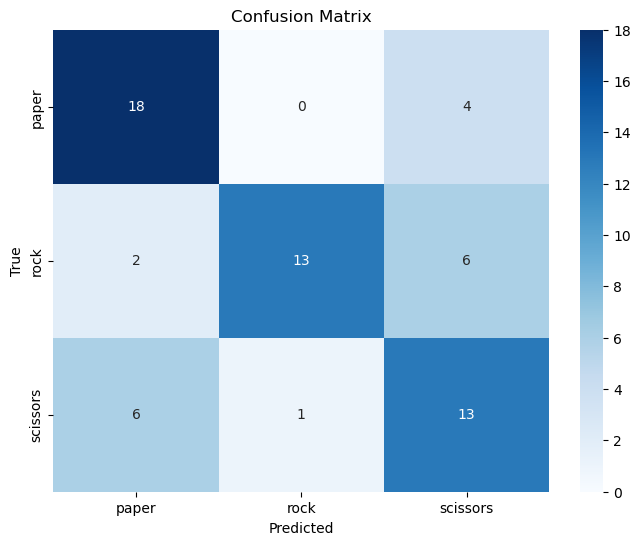

In [522]:
test_loader = DataLoader(test_dataset_tl, batch_size=32, shuffle=False)

model.eval()
test_preds_tl, test_labels_tl = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        test_preds_tl.extend(outputs.argmax(1).cpu().numpy())
        test_labels_tl.extend(labels.numpy())

test_acc_tl = accuracy_score(test_labels_tl, test_preds_tl)
precision_tl, recall_tl, f1_tl, _ = precision_recall_fscore_support(
    test_labels_tl, test_preds_tl, average='macro', zero_division=0
)

print(f"\nTest Performance (Transfer Learning):")
print(f"Accuracy: {test_acc_tl:.4f}")
print(f"Precision: {precision_tl:.4f}")
print(f"Recall: {recall_tl:.4f}")
print(f"F1-Score: {f1_tl:.4f}")
cm = confusion_matrix(test_labels_tl, test_preds_tl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


Test Performance (Transfer Learning TTA):
Accuracy: 0.6190
Precision: 0.6290
Recall: 0.6169
F1-Score: 0.6175


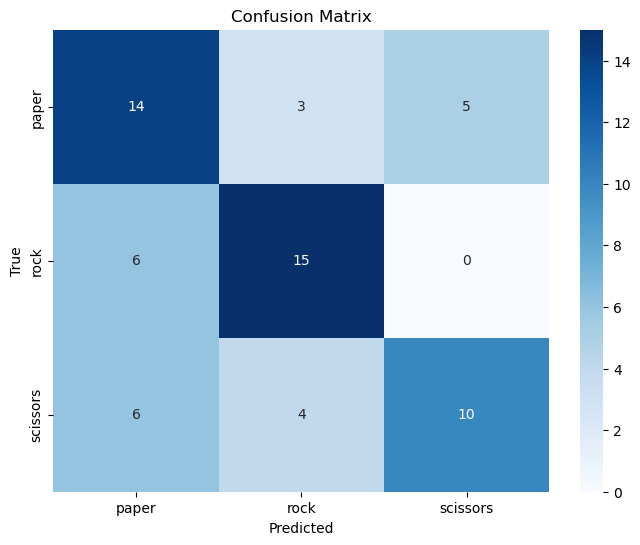

In [290]:
test_preds, test_labels = simple_tta(model, test_loader) 
test_acc_tl = accuracy_score(test_labels, test_preds)
precision_tl, recall_tl, f1_tl, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='macro', zero_division=0
)

print(f"\nTest Performance (Transfer Learning TTA):")
print(f"Accuracy: {test_acc_tl:.4f}")
print(f"Precision: {precision_tl:.4f}")
print(f"Recall: {recall_tl:.4f}")
print(f"F1-Score: {f1_tl:.4f}")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

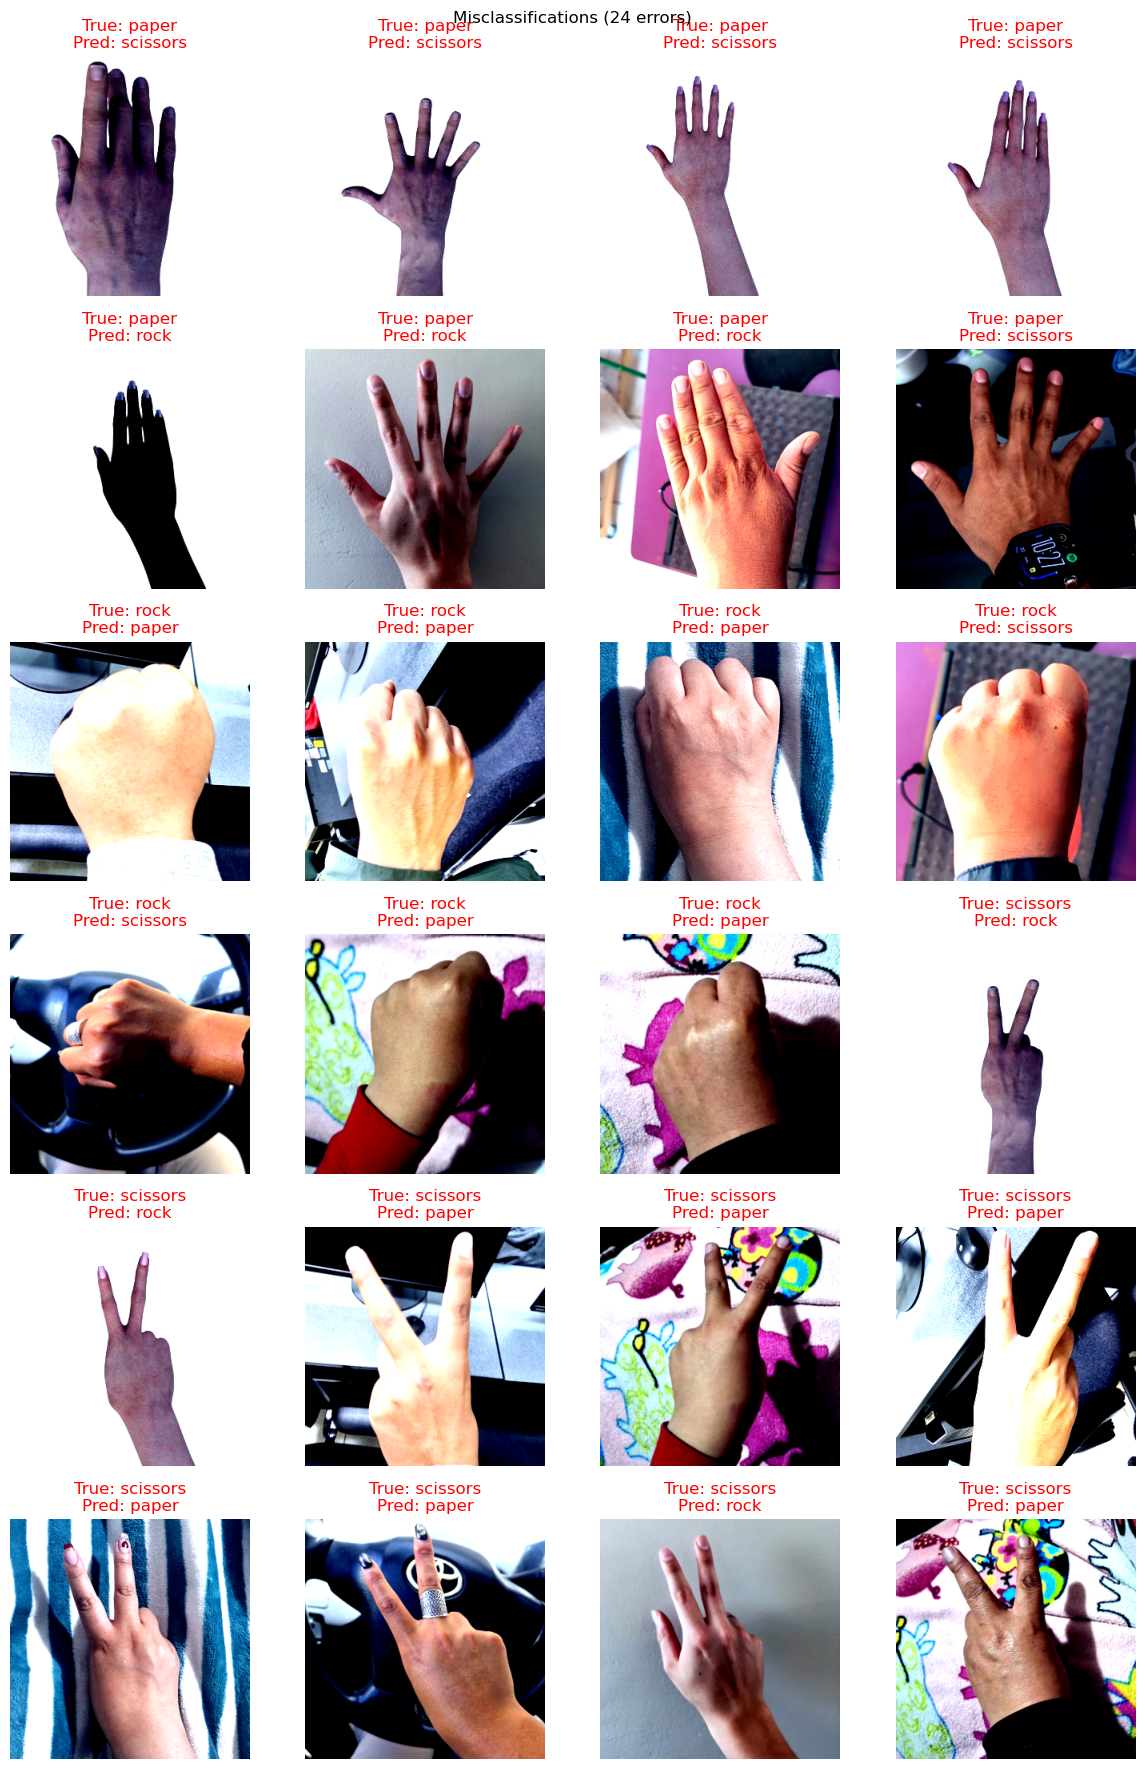


Total errors: 24 / 63


In [291]:
error_images_tl = show_errors(model, test_dataset_tl, max_images=24)
print(f"\nTotal errors: {len(error_images_tl)} / {len(test_dataset_tl)}")

## 3.5 Transfer Learning con transformaciones mas ligeras y teninedo un modelo más conservador

In [534]:
clear_memory()

Memory after cleanup: 11.76 GB


### 3.5.1 Arquitectura

In [535]:
class TransferLearningCNNv2_background(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.4):
        super().__init__()
        
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")

        for param in self.backbone.parameters():
            if 'layer4' not in name and 'fc' not in name:
                param.requires_grad = False
        
        # Replace classifier with heavy regularization
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def print_named_parameters(self):
        print(self.backbone.named_parameters())
    
    def forward(self, x):
        return self.backbone(x)

### 3.5.2 Procesamiento de datos

In [536]:
model = TransferLearningCNNv2().to(DEVICE)
train_dataset = HandGestureDataset(TRAIN_PATH, train_transform_imagenet_v2_simplified, "train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset_tl, batch_size=32, shuffle=False)

### 3.5.3 Asignación de pesos y función de perdida

In [537]:
weights = torch.tensor([1.0, 1.0, 2.0]).to(DEVICE)

criterion_2 = nn.CrossEntropyLoss(
    label_smoothing=0.15,
    weight=weights
)

### 3.5.4 Optimizador

In [538]:
# distintos LR para el backbone y el fc
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'layer4' in n], 
     'lr': 1e-5, 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if 'fc' in n], 
     'lr': 1e-4, 'weight_decay': 0.001}
])

### 3.5.5 Entrenamiento

In [539]:
test_loader = DataLoader(test_dataset_tl, batch_size=32, shuffle=False)

In [540]:
start_tl_v2 = time.time() 
history, val_acc = train_model(
    model, train_loader, valid_loader, criterion_2, optimizer,
    model_name=f"TransferLearningV2_cambio_fondo",
    num_epochs=20
)
end_tl_v2 = time.time()
training_time_tl_v2 = end_tl_v2 - start_tl_v2
print(f'El modelo Transfer Learning - Resnet18, con cambio de fondo, fue entrenado en {round(training_time_tl_v2,3)} segundos')
history_transferLearning_change_white_background = history

Epoch 01 | Train: 0.3480 | Val: 0.3333
Epoch 02 | Train: 0.3956 | Val: 0.3710
Epoch 03 | Train: 0.4488 | Val: 0.6210
Epoch 04 | Train: 0.5115 | Val: 0.7339
Epoch 05 | Train: 0.5563 | Val: 0.8333
Epoch 06 | Train: 0.6040 | Val: 0.8710
Epoch 07 | Train: 0.6353 | Val: 0.9167
Epoch 08 | Train: 0.6504 | Val: 0.8548
Epoch 09 | Train: 0.6631 | Val: 0.8763
Epoch 10 | Train: 0.6659 | Val: 0.9086
Epoch 11 | Train: 0.6655 | Val: 0.9382
Epoch 12 | Train: 0.7063 | Val: 0.9301
Epoch 13 | Train: 0.7052 | Val: 0.9435
Epoch 14 | Train: 0.7000 | Val: 0.8978
Epoch 15 | Train: 0.7075 | Val: 0.9032
Epoch 16 | Train: 0.6937 | Val: 0.9247
Epoch 17 | Train: 0.7135 | Val: 0.9409
Epoch 18 | Train: 0.6968 | Val: 0.9194
Epoch 19 | Train: 0.7385 | Val: 0.9301
Epoch 20 | Train: 0.7250 | Val: 0.9247
Early stopping at epoch 20
El modelo Transfer Learning - Resnet18, con cambio de fondo, fue entrenado en 570.181 segundos


### 3.5.6 Evaluación



Test Performance (Transfer Learning TTA - Efecto de reemplazar fondos):
Accuracy: 0.7302
Precision: 0.7403
Recall: 0.7297
F1-Score: 0.7328


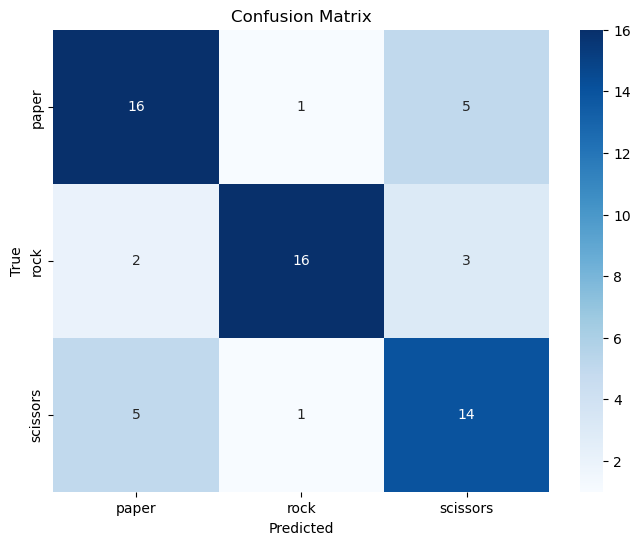

In [541]:
test_preds, test_labels = simple_tta(model, test_loader) 
test_acc_tl = accuracy_score(test_labels, test_preds)
precision_tl, recall_tl, f1_tl, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='macro', zero_division=0
)

print(f"\nTest Performance (Transfer Learning TTA - Efecto de reemplazar fondos):")
print(f"Accuracy: {test_acc_tl:.4f}")
print(f"Precision: {precision_tl:.4f}")
print(f"Recall: {recall_tl:.4f}")
print(f"F1-Score: {f1_tl:.4f}")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

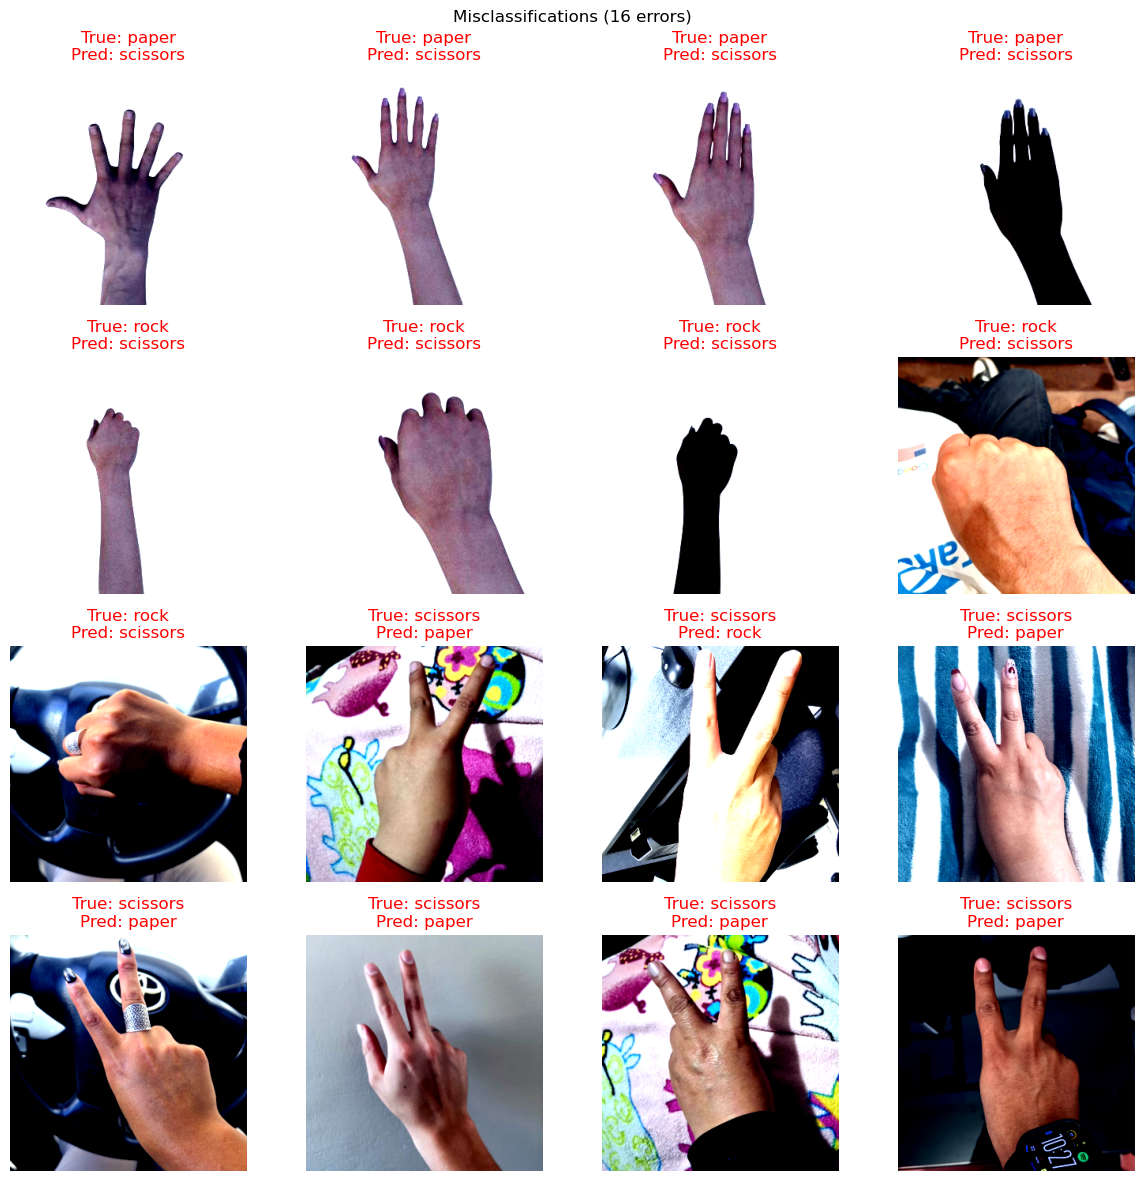


Total errors: 16 / 63


In [542]:
error_images_tl = show_errors(model, test_dataset_tl, max_images=24)
print(f"\nTotal errors: {len(error_images_tl)} / {len(test_dataset_tl)}")

### Ejemplo de aplicación de las transformaciones

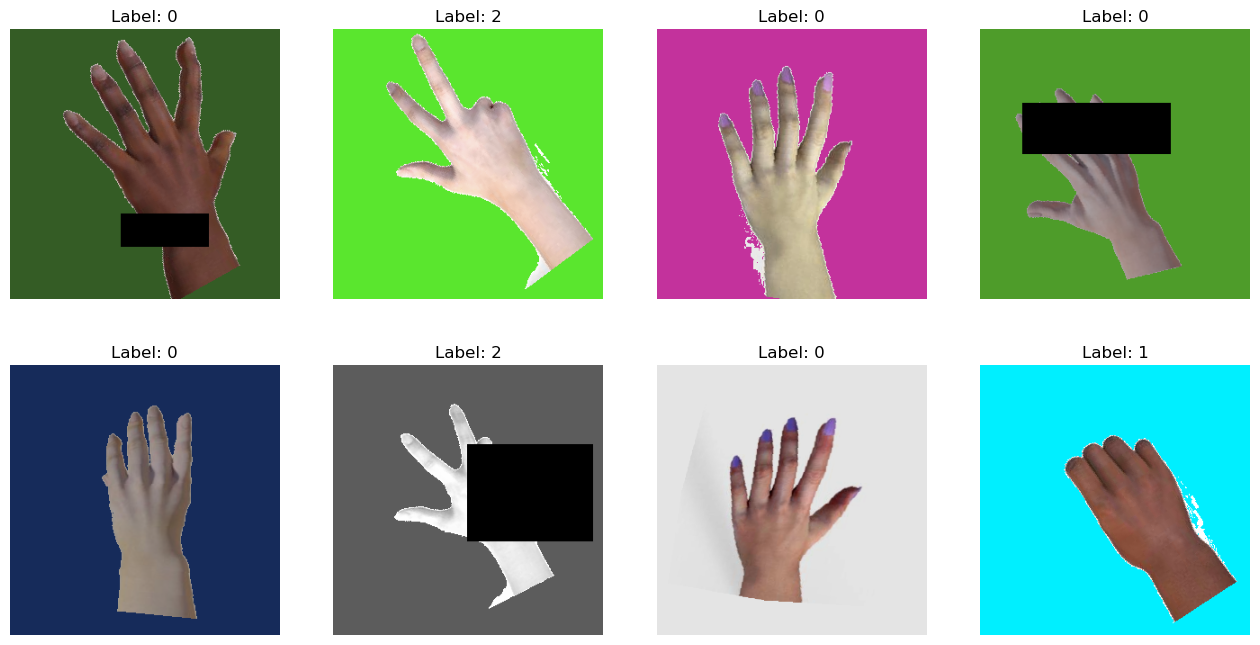

In [438]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to un-normalize and display
def show_batch(dataloader):
    # Get one batch
    images, labels = next(iter(dataloader))
    
    plt.figure(figsize=(16, 8))
    for i in range(min(8, len(images))): # Show top 8 images
        ax = plt.subplot(2, 4, i + 1)
        
        # Undo normalization for display: img = img * std + mean
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # Clip to valid range
        
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

# Assuming you have your train_loader defined
show_batch(train_loader)

In [599]:
clear_memory()

Memory after cleanup: 11.86 GB


## 3.6 CNN (arquitectura SqueezeNetV1)

### 3.6.1 Arquitectura

Se usa la arquitectura que ya está en pytorch de mobilenet large

In [672]:
class SqueezeNetScratch(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(SqueezeNetScratch, self).__init__()
        
        self.features = nn.Sequential(
            # Conv1 + MaxPool1
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is self.classifier[1]:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [673]:
model = SqueezeNetScratch(num_classes=3).to(device)

In [674]:
print(f"SqueezeNet Params: {sum(p.numel() for p in model.parameters())}")

SqueezeNet Params: 724035


### 3.6.2 Procesamiento de datos

In [675]:
train_dataset = HandGestureDataset(TRAIN_PATH, train_transform_imagenet_v2_simplified, "train")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset_tl, batch_size=128, shuffle=False)

### 3.6.3 Funcion loss y optimizador

In [676]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# criterion
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

### 3.6.4 Entrenamiento del modelo

In [677]:
start_squeeze = time.time() 
history, val_acc = train_model(
    model, train_loader, valid_loader, criterion_2, optimizer,
    model_name=f"SqueezeNet",
    num_epochs=30
)
end_squeeze = time.time()
training_time_squeeze = end_squeeze - start_squeeze
print(f'El modelo SqueezeNet fue entrenado en {round(training_time_squeeze,3)} segundos')
history_squeeze = history

Epoch 01 | Train: 0.3377 | Val: 0.3333
Epoch 02 | Train: 0.3500 | Val: 0.4651
Epoch 03 | Train: 0.3615 | Val: 0.5296
Epoch 04 | Train: 0.4889 | Val: 0.5726
Epoch 05 | Train: 0.5782 | Val: 0.5511
Epoch 06 | Train: 0.6198 | Val: 0.7876
Epoch 07 | Train: 0.7329 | Val: 0.7097
Epoch 08 | Train: 0.7952 | Val: 0.8763
Epoch 09 | Train: 0.8333 | Val: 0.9005
Epoch 10 | Train: 0.8563 | Val: 0.9113
Epoch 11 | Train: 0.8909 | Val: 0.9597
Epoch 12 | Train: 0.9048 | Val: 0.7796
Epoch 13 | Train: 0.8885 | Val: 0.9032
Epoch 14 | Train: 0.9024 | Val: 0.9731
Epoch 15 | Train: 0.9270 | Val: 0.9624
Epoch 16 | Train: 0.9179 | Val: 0.9651
Epoch 17 | Train: 0.9349 | Val: 0.9597
Epoch 18 | Train: 0.9456 | Val: 0.9570
Epoch 19 | Train: 0.9472 | Val: 0.9651
Epoch 20 | Train: 0.9437 | Val: 0.9731
Epoch 21 | Train: 0.9464 | Val: 0.9758
Epoch 22 | Train: 0.9369 | Val: 0.9785
Epoch 23 | Train: 0.9437 | Val: 0.9677
Epoch 24 | Train: 0.9567 | Val: 0.9892
Epoch 25 | Train: 0.9532 | Val: 0.9597
Epoch 26 | Train: 0.9627 

### 3.6.5 Evaluación con TTA

In [682]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test Performance (SqueezeNet TTA - con transformaciones complejas):
Accuracy: 0.7302
Precision: 0.7722
Recall: 0.7260
F1-Score: 0.7280


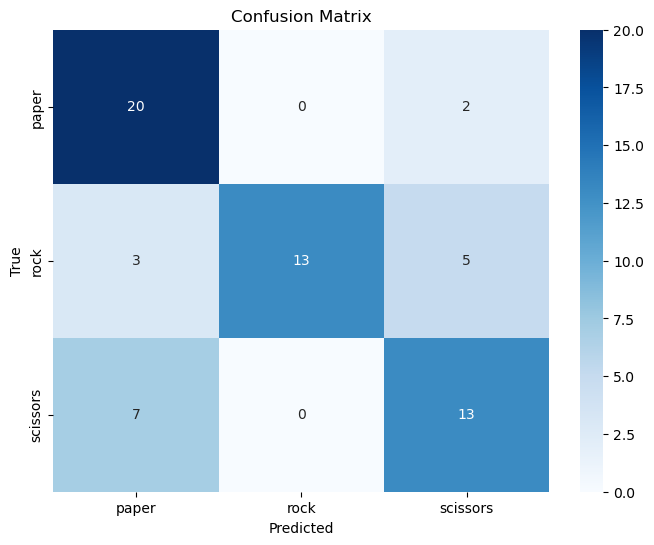

In [683]:
test_preds, test_labels = simple_tta(model, test_loader) 
test_acc_tl = accuracy_score(test_labels, test_preds)
precision_tl, recall_tl, f1_tl, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='macro', zero_division=0
)

print(f"\nTest Performance (SqueezeNet TTA - con transformaciones complejas):")
print(f"Accuracy: {test_acc_tl:.4f}")
print(f"Precision: {precision_tl:.4f}")
print(f"Recall: {recall_tl:.4f}")
print(f"F1-Score: {f1_tl:.4f}")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

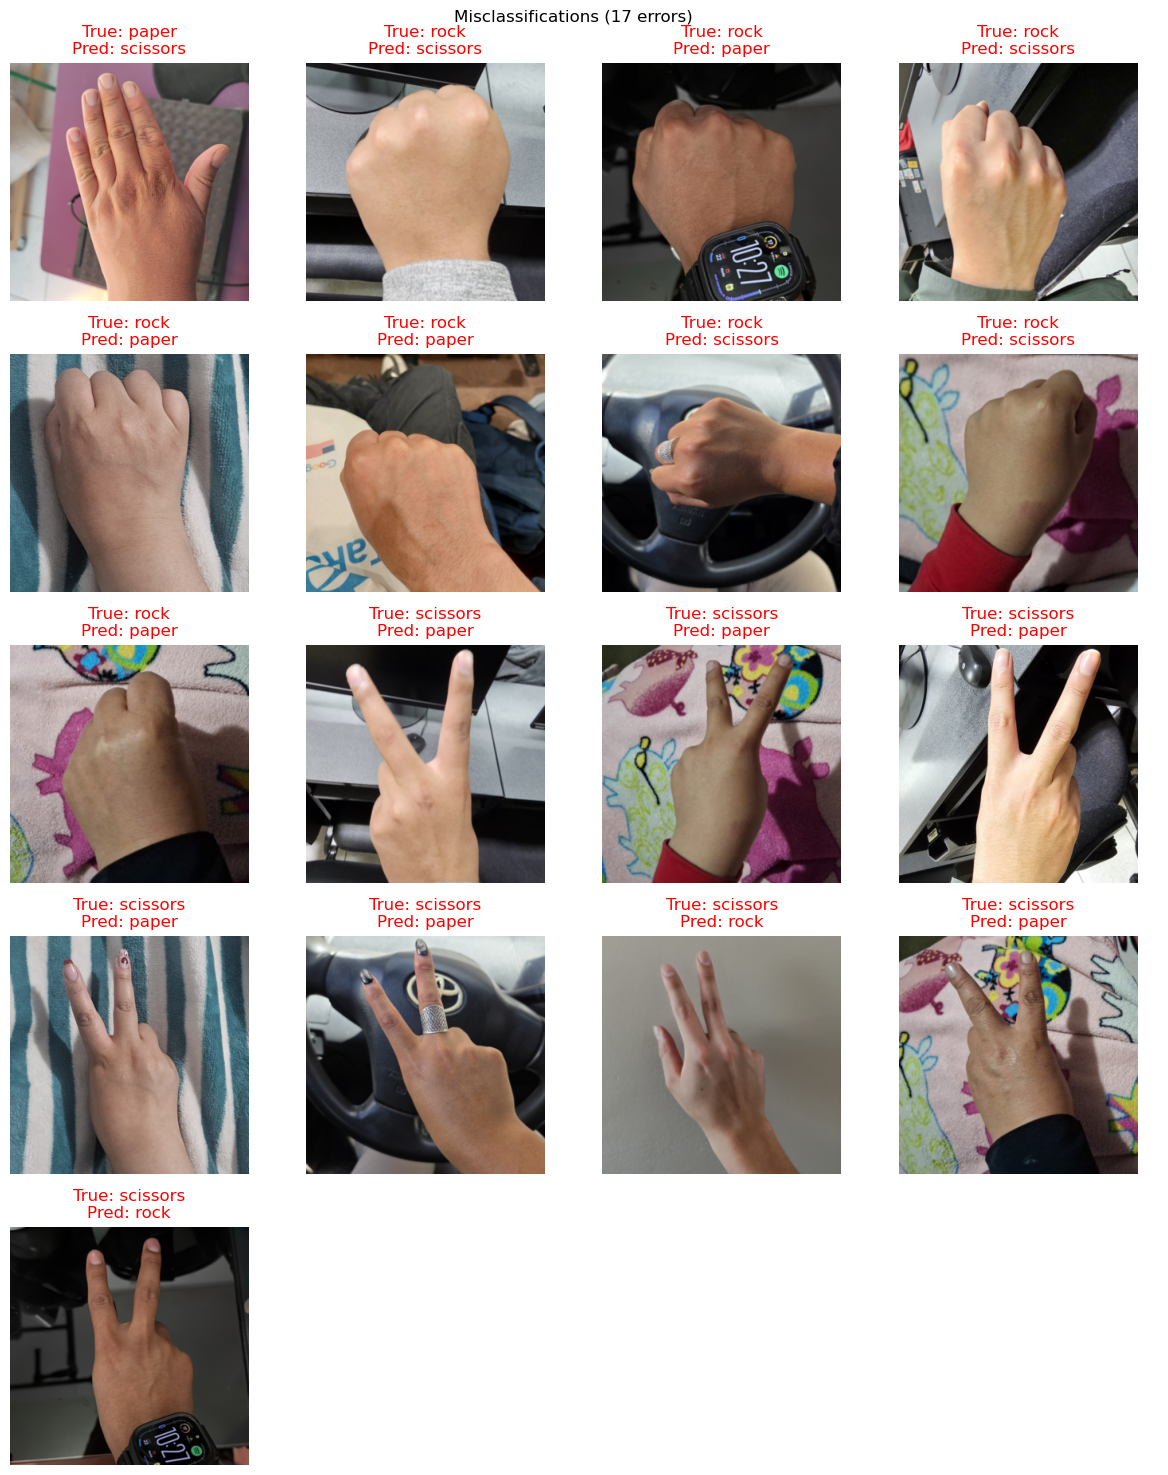


Total errors: 17 / 63


In [684]:
error_images_tl = show_errors(model, test_dataset, max_images=24)
print(f"\nTotal errors: {len(error_images_tl)} / {len(test_dataset_tl)}")

> Claramente hay un gap en el estudio del dominio, para intentar sobrepasar este problema se intentará hacer una experimentación con transformaciones diferentes

In [716]:
clear_memory()

Memory after cleanup: 7.25 GB


## 3.7 CNN (arquitectura Mix con SqueezeNet)

### 3.7.1 Arquitectura

In [25]:
class DenseNetScratch(nn.Module):
    def __init__(self, num_classes=3, growth_rate=12, dropout_rate=0.2):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(2 * growth_rate),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        num_features = 2 * growth_rate
        
        block_config = (4, 8, 16) 
        
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            
            if i != len(block_config) - 1:
                trans = TransitionLayer(num_features, num_features // 2)
                self.blocks.append(trans)
                num_features = num_features // 2
        
        self.final_bn = nn.BatchNorm2d(num_features)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.features(x)
        
        for block in self.blocks:
            out = block(out)
            
        out = F.relu(self.final_bn(out))
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [26]:
model = DenseNetScratch().to(device)

### 3.7.2 Procesamiento de datos

In [27]:
train_dataset = HandGestureDataset(TRAIN_PATH, train_transform_imagenet_v2_simplified, "train")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

### 3.7.3 Función Loss y Optimizer

In [28]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# criterion
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

### 3.7.4 Entrenamiento

In [29]:
start_dense = time.time() 
history, val_acc = train_model(
    model, train_loader, valid_loader, criterion_2, optimizer,
    model_name=f"SqueezeNetMix",
    num_epochs=30
)
end_dense = time.time()
training_time_dense = end_dense - start_dense
print(f'El modelo SqueezeNetMix fue entrenado en {round(training_time_dense,3)} segundos')
history_dense = history

Epoch 01 | Train: 0.3433 | Val: 0.3333
Epoch 02 | Train: 0.3762 | Val: 0.3333
Epoch 03 | Train: 0.4095 | Val: 0.3333
Epoch 04 | Train: 0.4417 | Val: 0.3333
Epoch 05 | Train: 0.5409 | Val: 0.3333
Epoch 06 | Train: 0.5996 | Val: 0.3360
Epoch 07 | Train: 0.6790 | Val: 0.4651
Epoch 08 | Train: 0.7083 | Val: 0.5645
Epoch 09 | Train: 0.7401 | Val: 0.4382
Epoch 10 | Train: 0.7710 | Val: 0.5968
Epoch 11 | Train: 0.7937 | Val: 0.5484
Epoch 12 | Train: 0.8242 | Val: 0.5027
Epoch 13 | Train: 0.8631 | Val: 0.5269
Epoch 14 | Train: 0.8663 | Val: 0.7473
Epoch 15 | Train: 0.8873 | Val: 0.5726
Epoch 16 | Train: 0.9063 | Val: 0.6048
Epoch 17 | Train: 0.9274 | Val: 0.7769
Epoch 18 | Train: 0.9317 | Val: 0.7930
Epoch 19 | Train: 0.9373 | Val: 0.7957
Epoch 20 | Train: 0.9468 | Val: 0.7930
Epoch 21 | Train: 0.9480 | Val: 0.8844
Epoch 22 | Train: 0.9528 | Val: 0.8710
Epoch 23 | Train: 0.9567 | Val: 0.8172
Epoch 24 | Train: 0.9627 | Val: 0.8468
Epoch 25 | Train: 0.9504 | Val: 0.7849
Epoch 26 | Train: 0.9552 

### 3.7.5 Evaluación

In [30]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test Performance (Dense CNN  - Efecto de reemplazar fondos):
Accuracy: 0.7302
Precision: 0.7306
Recall: 0.7266
F1-Score: 0.7226


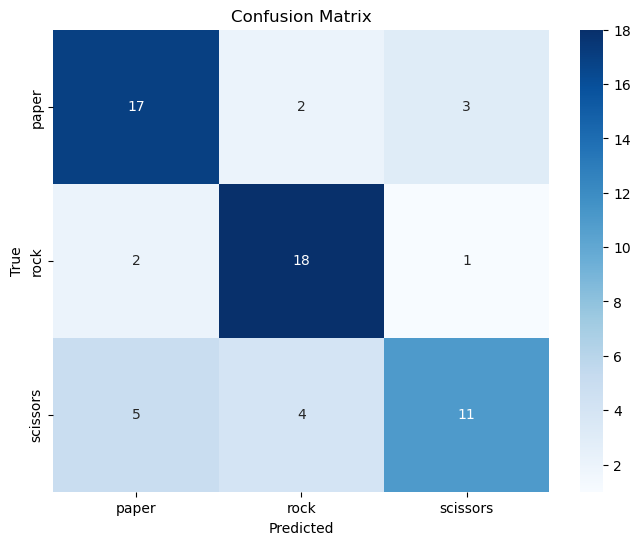

In [35]:
test_preds, test_labels = simple_tta(model, test_loader) 
test_acc_tl = accuracy_score(test_labels, test_preds)
precision_tl, recall_tl, f1_tl, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='macro', zero_division=0
)

print(f"\nTest Performance (Dense CNN  - Efecto de reemplazar fondos):")
print(f"Accuracy: {test_acc_tl:.4f}")
print(f"Precision: {precision_tl:.4f}")
print(f"Recall: {recall_tl:.4f}")
print(f"F1-Score: {f1_tl:.4f}")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()